## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.io.wavfile import read, write
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import os

from tensorflow.keras.utils import pad_sequences

## Load .wav data

In [5]:
def read_wav(file_names):
    a = read(file_names)
    return np.array(a[1], dtype=np.float64)

In [6]:
AS = np.array([read_wav(os.path.join("AS", filename)) for filename in os.listdir("AS")], dtype=object)
MR = np.array([read_wav(os.path.join("MR", filename)) for filename in os.listdir("MR")], dtype=object)
MS = np.array([read_wav(os.path.join("MS", filename)) for filename in os.listdir("MS")], dtype=object)
MVP = np.array([read_wav(os.path.join("MVP", filename)) for filename in os.listdir("MVP")], dtype=object)
N = np.array([read_wav(os.path.join("N", filename)) for filename in os.listdir("N")], dtype=object)

## Normalization

In [7]:
for i in range(200):
    AS[i] = (AS[i]-min(AS[i])) / (max(AS[i]-min(AS[i]))) * 2 -1
    MR[i] = (MR[i]-min(MR[i])) / (max(MR[i]-min(MR[i]))) * 2 -1
    MS[i] = (MS[i]-min(MS[i])) / (max(MS[i]-min(MS[i]))) * 2 -1
    MVP[i] = (MVP[i]-min(MVP[i])) / (max(MVP[i]-min(MVP[i]))) * 2 -1
    N[i] = (N[i]-min(N[i])) / (max(N[i]-min(N[i]))) * 2 -0.5

## Padding

In [8]:
lengths = [len(a) for a in AS] + [len(a) for a in MR] + [len(a) for a in MS] + [len(a) for a in MVP] \
           + [len(a) for a in N]

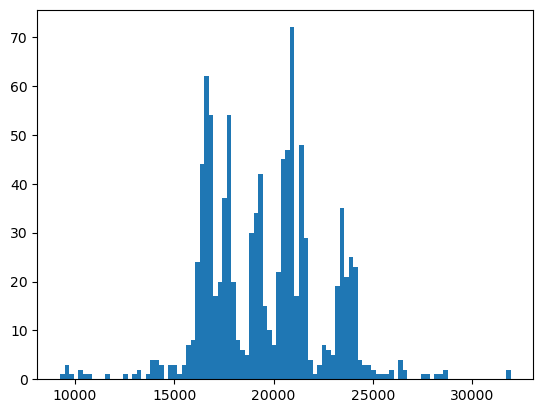

In [9]:
plt.hist(lengths, bins=100)
plt.show()

In [10]:
MAXLEN = 20000
AS = pad_sequences(AS, maxlen=MAXLEN, dtype=np.float32, padding='post', truncating='post')
MS = pad_sequences(MS, maxlen=MAXLEN, dtype=np.float32, padding='post', truncating='post')
MR = pad_sequences(MR, maxlen=MAXLEN, dtype=np.float32, padding='post', truncating='post')
MVP = pad_sequences(MVP, maxlen=MAXLEN, dtype=np.float32, padding='post', truncating='post')
N = pad_sequences(N, maxlen=MAXLEN, dtype=np.float32, padding='post', truncating='post')

## Average Pooling

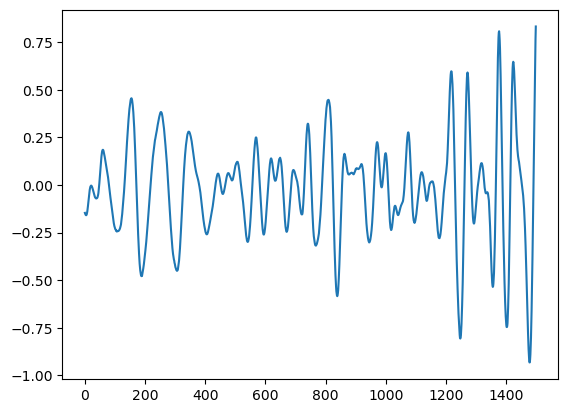

In [11]:
data = AS[0]
plt.plot(data[5000+2500:5000+4000])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-08-18 04:07:57.913099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-18 04:07:57.915360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


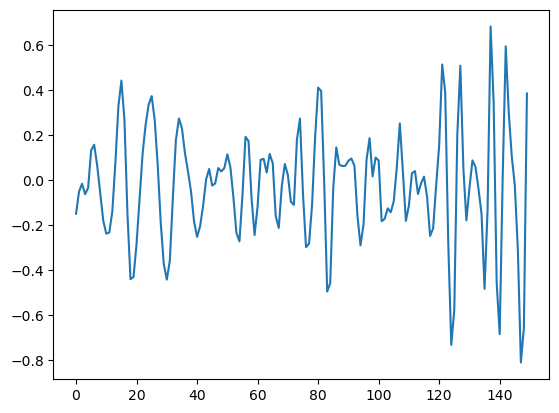

In [12]:
pooling = keras.layers.AveragePooling1D(pool_size=10)

data = tf.reshape(data, [1, 20000, 1])
pooled = tf.reshape(pooling(data), pooling(data).shape[1])
plt.plot(pooled[300+400+50:300+400+50+150])

In [13]:
AS = np.array([tf.reshape(pooling(tf.reshape(a, [1, 20000, 1])), 2000) for a in AS])
MR = np.array([tf.reshape(pooling(tf.reshape(a, [1, 20000, 1])), 2000) for a in MR])
MS = np.array([tf.reshape(pooling(tf.reshape(a, [1, 20000, 1])), 2000) for a in MS])
MVP = np.array([tf.reshape(pooling(tf.reshape(a, [1, 20000, 1])), 2000) for a in MVP])
N = np.array([tf.reshape(pooling(tf.reshape(a, [1, 20000, 1])), 2000) for a in N])

In [14]:
def shuffle(X):
    X_shuffled = []
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.shuffle(buffer_size=500).batch(1)
    for x in dataset:
        X_shuffled.append(x)
    return np.array(X_shuffled)

AS = shuffle(AS)
MR = shuffle(MR)
MS = shuffle(MS)
MVP = shuffle(MVP)
N = shuffle(N)
    

## Create labels

In [17]:
Y = np.concatenate((np.zeros(200), np.ones(200), 2*np.ones(200), 3*np.ones(200), 4*np.ones(200)))

## Save data as .npz file

In [18]:
X = np.concatenate((AS, MR, MS, MVP, N))
np.savez("data.npz", X=X, Y=Y)